In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
# Import modules
import numpy as np # maths

from time import time# timer for debug

    # gather results obtained from the runs

    # system commands
import os
    
    # interact with the C++ core and the Python core
import dimers as dim # C++ interface module
import KagomeFunctions as kf # "library" allowing to work on Kagome
import KagomeDrawing as kdraw # "library" allowing to plot Kagome
import Observables as obs #observables that can be used by the run script
import KagomeFT as kft #small functions to compute the FT
import AnalysisFunctions as af # functions to make the analysis code cleaner
    #plots using matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams.update({'font.size': 14, 'pgf.texsystem':'pdflatex'})

In [3]:
# Create a folder to save the pictures
foldername = '../../MFUs/Tests_31-08-20_EasyPhase/'
#foldername = '../Analysis_PSI/Runs_12-11-19_ssfMagnField/'
results_foldername = 'Results_01-09-20/'
os.makedirs('./' + foldername + results_foldername, exist_ok = True)

filenamelist = ['KEasyPhase_L4_nsm262144_it0_folder/backup',
                'KEasyPhase_L4_nsm262144_it1_folder/backup']
n = len(filenamelist)

In [4]:
mergeruns = True
kw = {'mergeruns':mergeruns}

[L, numsites, J1, J2, J3, J3st, J4, nb, num_in_bin, 
 htip, Ttip, pswitch, uponly, path,
 temperatures, nt,
 stat_temps, temperatures_plots, hfields, nh, 
 stat_hfields, hfields_plots, listfunctions, sref, ids2walker] = \
af.LoadParameters(foldername, filenamelist, **kw)

s_ijl, ijl_s = kdraw.createspinsitetable(L[0])
print("nb ", nb, "num_in_bin ", num_in_bin)
swapst_th, swapsh_th, swapst, swapsh = af.LoadSwaps(foldername, filenamelist, nb, num_in_bin, nh, nt, **kw)


failedth, failedssfth, failed, failedssf = \
af.LoadUpdates(foldername, filenamelist, nb, num_in_bin, [9*L[i]**2 for i in range(n)], **kw)


nb  [256, 256] num_in_bin  [1024, 1024]


In [5]:
np.log(2)

0.6931471805599453

In [6]:

kw = {'binning': True, 'plzplot': False, 'RS':True, 'S0':np.log(2), 'mergeruns':mergeruns}
[t_h_MeanE, t_h_MeanEsq, t_h_varMeanE, t_h_varMeanEsq, C, ErrC,
 t_h_S, t_h_Smin, t_h_Smax, MergedData ] = \
 af.LoadEnergy(foldername, filenamelist, numsites,
               nb, stat_temps, temperatures, stat_hfields, listfunctions, **kw)

if mergeruns:
    [t_h_MeanE, t_h_MeanEsq, t_h_varMeanE, t_h_varMeanEsq, C, ErrC,
 t_h_S, t_h_Smin, t_h_Smax] = MergedData

Binning...Energy
 bins list for binning:  [256, 128, 64, 32, 16]
[-1.73333333]
Binning...Energy
 bins list for binning:  [256, 128, 64, 32, 16]
Binning...Energy
 bins list for binning:  [256, 128, 64, 32, 16]
[-1.73333333]
Binning...Energy
 bins list for binning:  [256, 128, 64, 32, 16]
(256, 1)


In [ ]:
#t_MeanM, t_MeanMsq, t_varMeanM, t_varMeanMsq, Chi, ErrChi = \
# af.LoadMagnetisation(foldername, filenamelist, numsites, nb,
#                      stat_temps, temperatures, listfunctions, **kw)

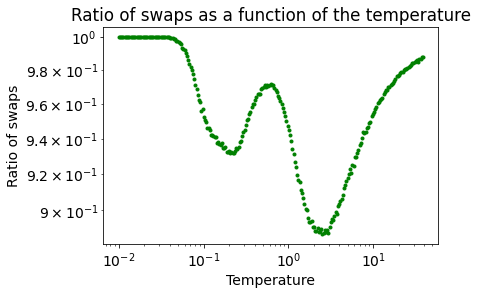

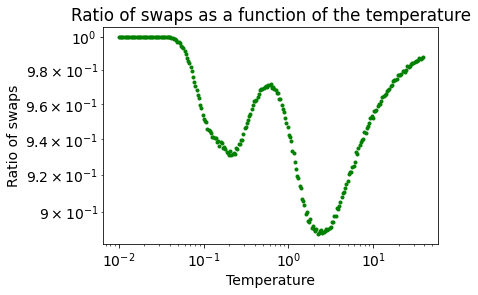

In [7]:
###########################################
        ## ALGORITHM ANALYSIS ##
###########################################
tidmin = 0
tidmax = nt
af.SwapsAnalysis(L, n, tidmin, tidmax, temperatures, hfields,
                 foldername, results_foldername, swapst, swapsh)

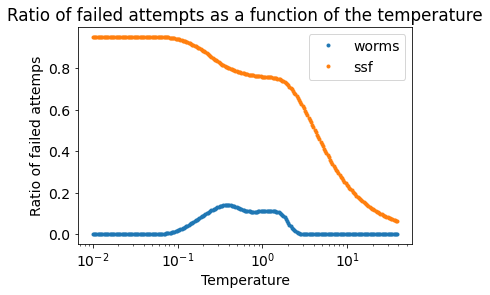

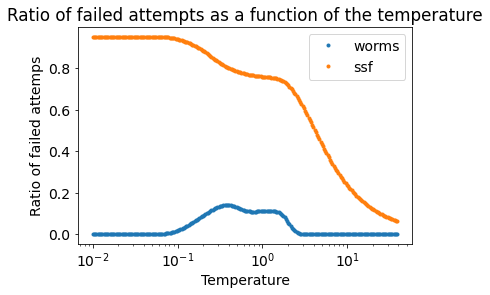

In [8]:
af.FailedAnalysis(L, n, tidmin, tidmax, temperatures, hfields,
                 foldername, results_foldername,failed, failedssf)

In [9]:
import importlib
importlib.reload(af)

<module 'AnalysisFunctions' from '/home/jcolbois/myopic-dual-worm/dualworm-kagome/AnalysisFunctions.py'>

In [10]:
tidmin = 0
tidmax = [len(stat_temps[i]) for i in range(n)]
temperatures_plots = np.array(temperatures_plots)
S0 = np.log(2)
kw = {'gscheck': True, 'S0': S0, 'RS': True, 't_h_EntropyData': (t_h_S, t_h_Smin, t_h_Smax) }


In [11]:
t_h_S[0].shape

(256, 1)

In [13]:
t_h_Smin[0][0:5]

array([[0.13663802],
       [0.13663802],
       [0.13663802],
       [0.13663802],
       [0.13663802]])

In [14]:
t_h_Smax[0][0:5]

array([[0.1391688],
       [0.1391688],
       [0.1391688],
       [0.1391688],
       [0.1391688]])

In [15]:
t_h_S[0][0:5]

array([[0.13790341],
       [0.13790341],
       [0.13790341],
       [0.13790341],
       [0.13790341]])

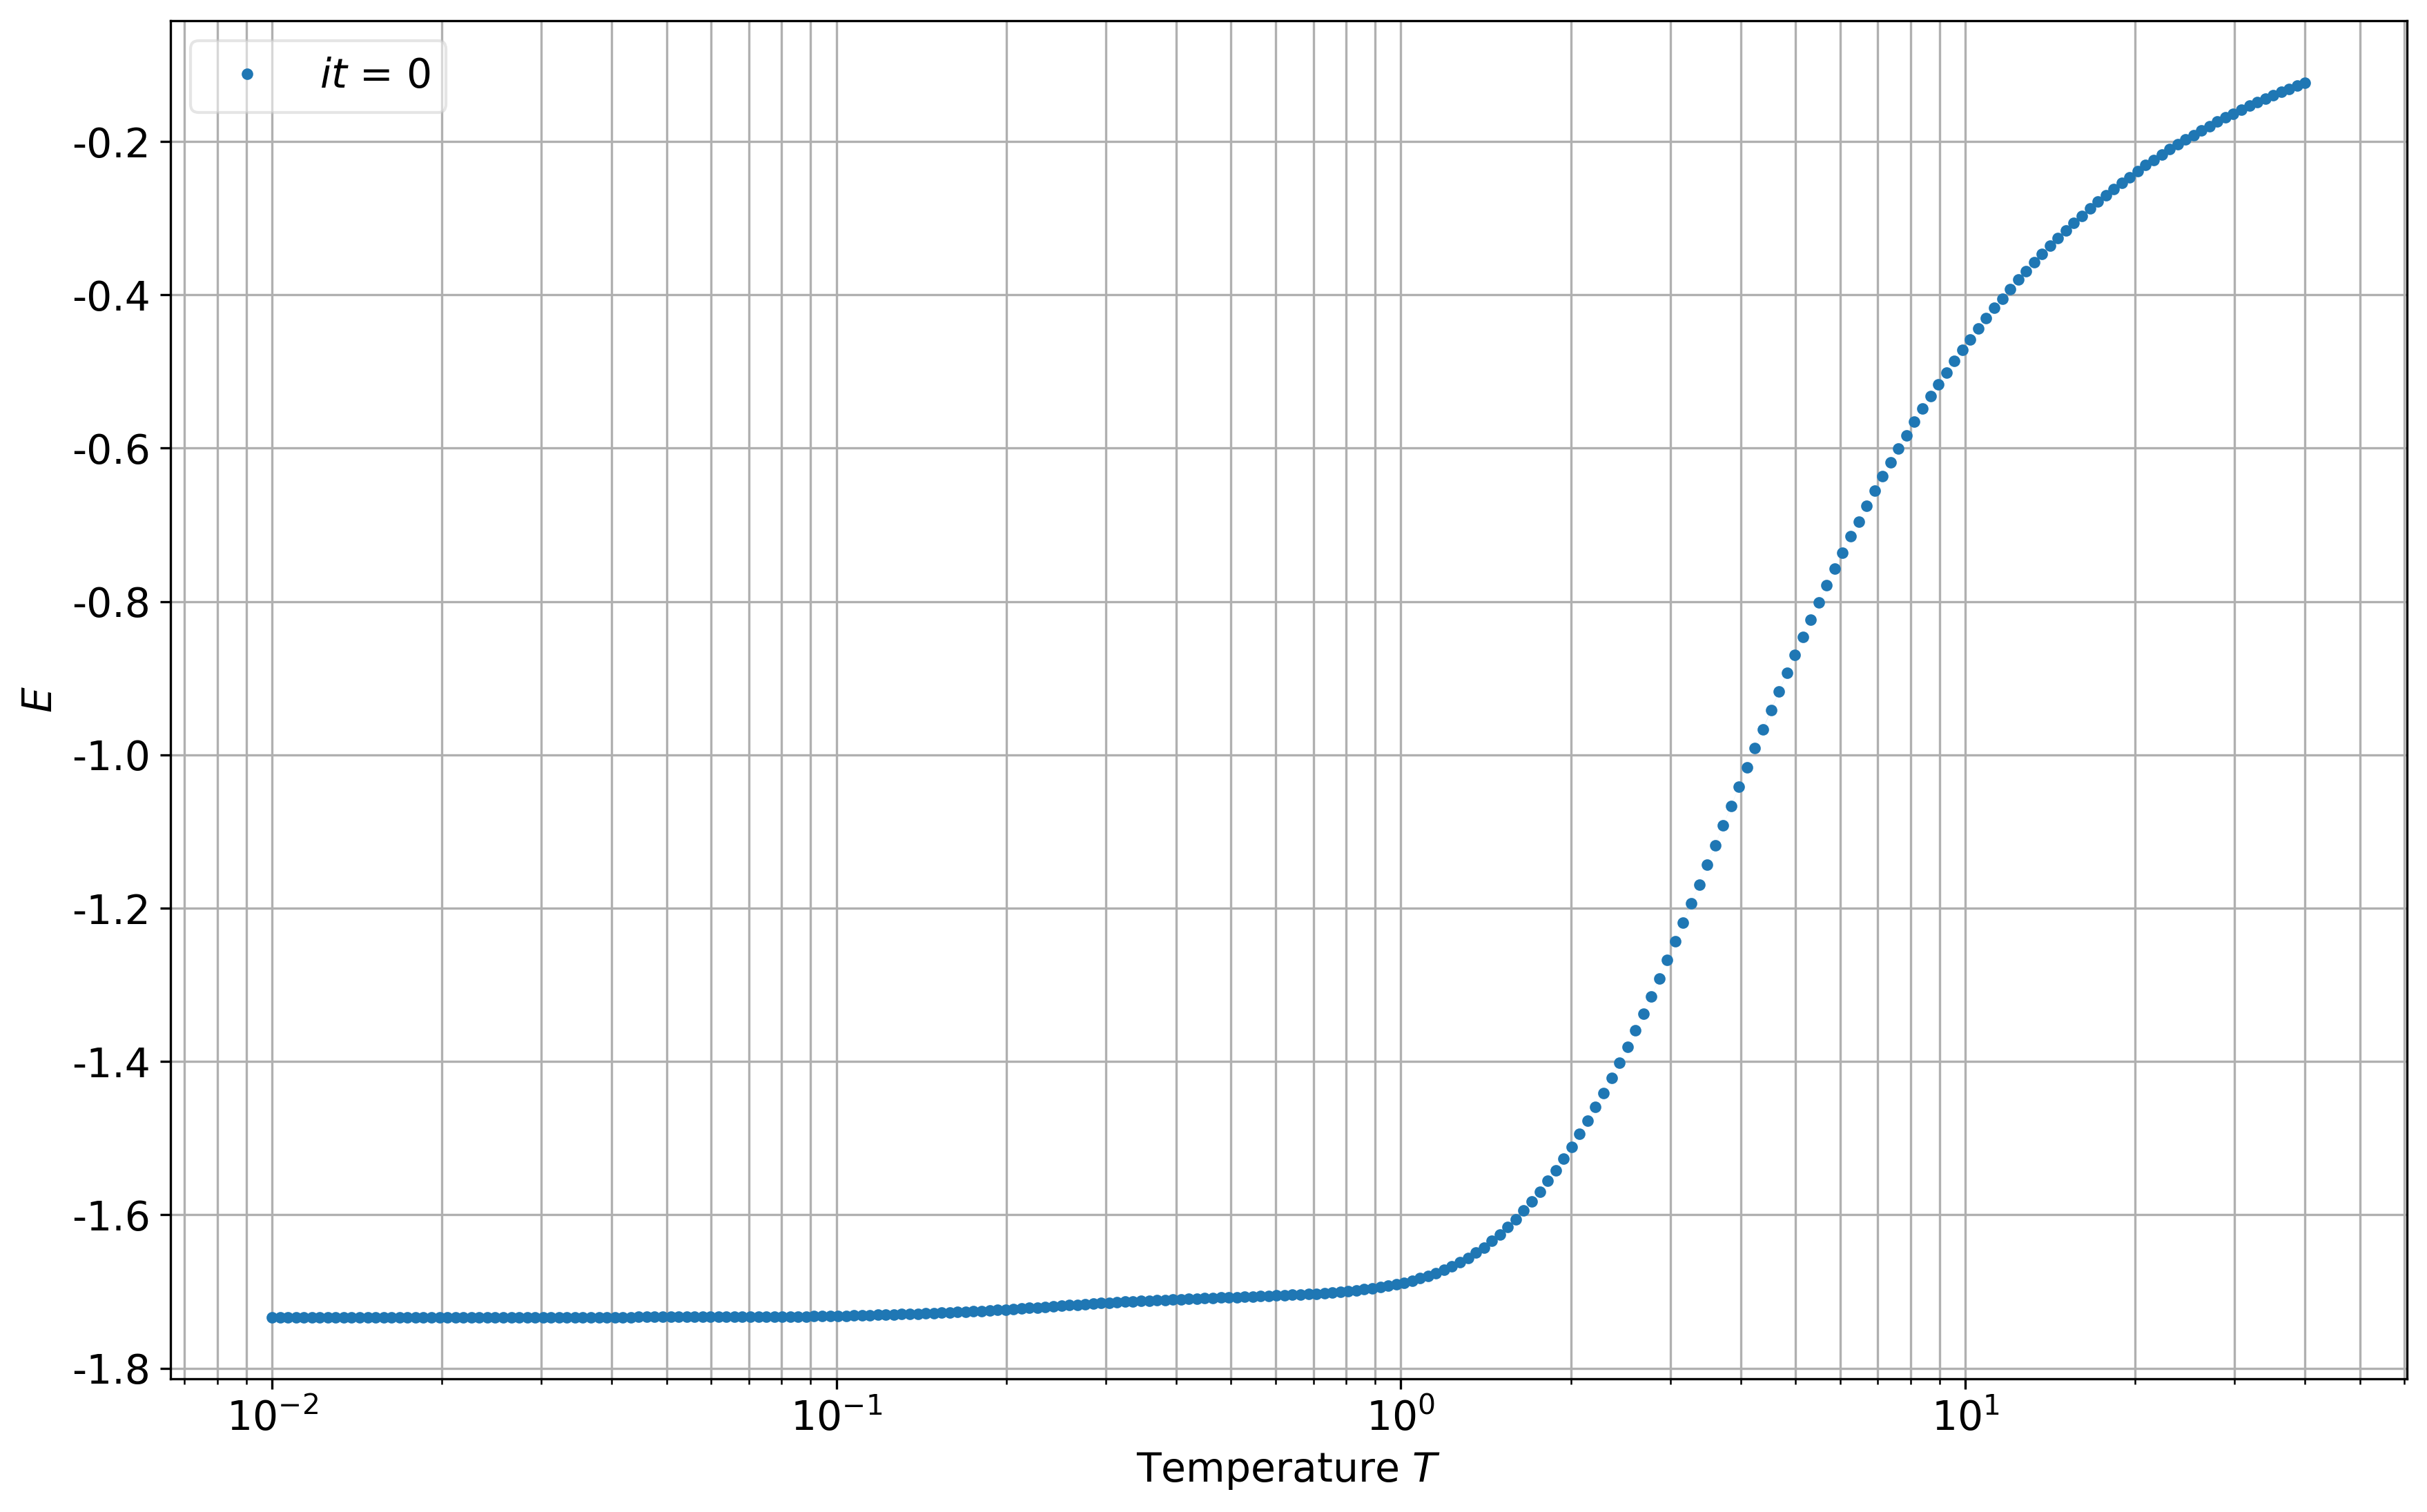

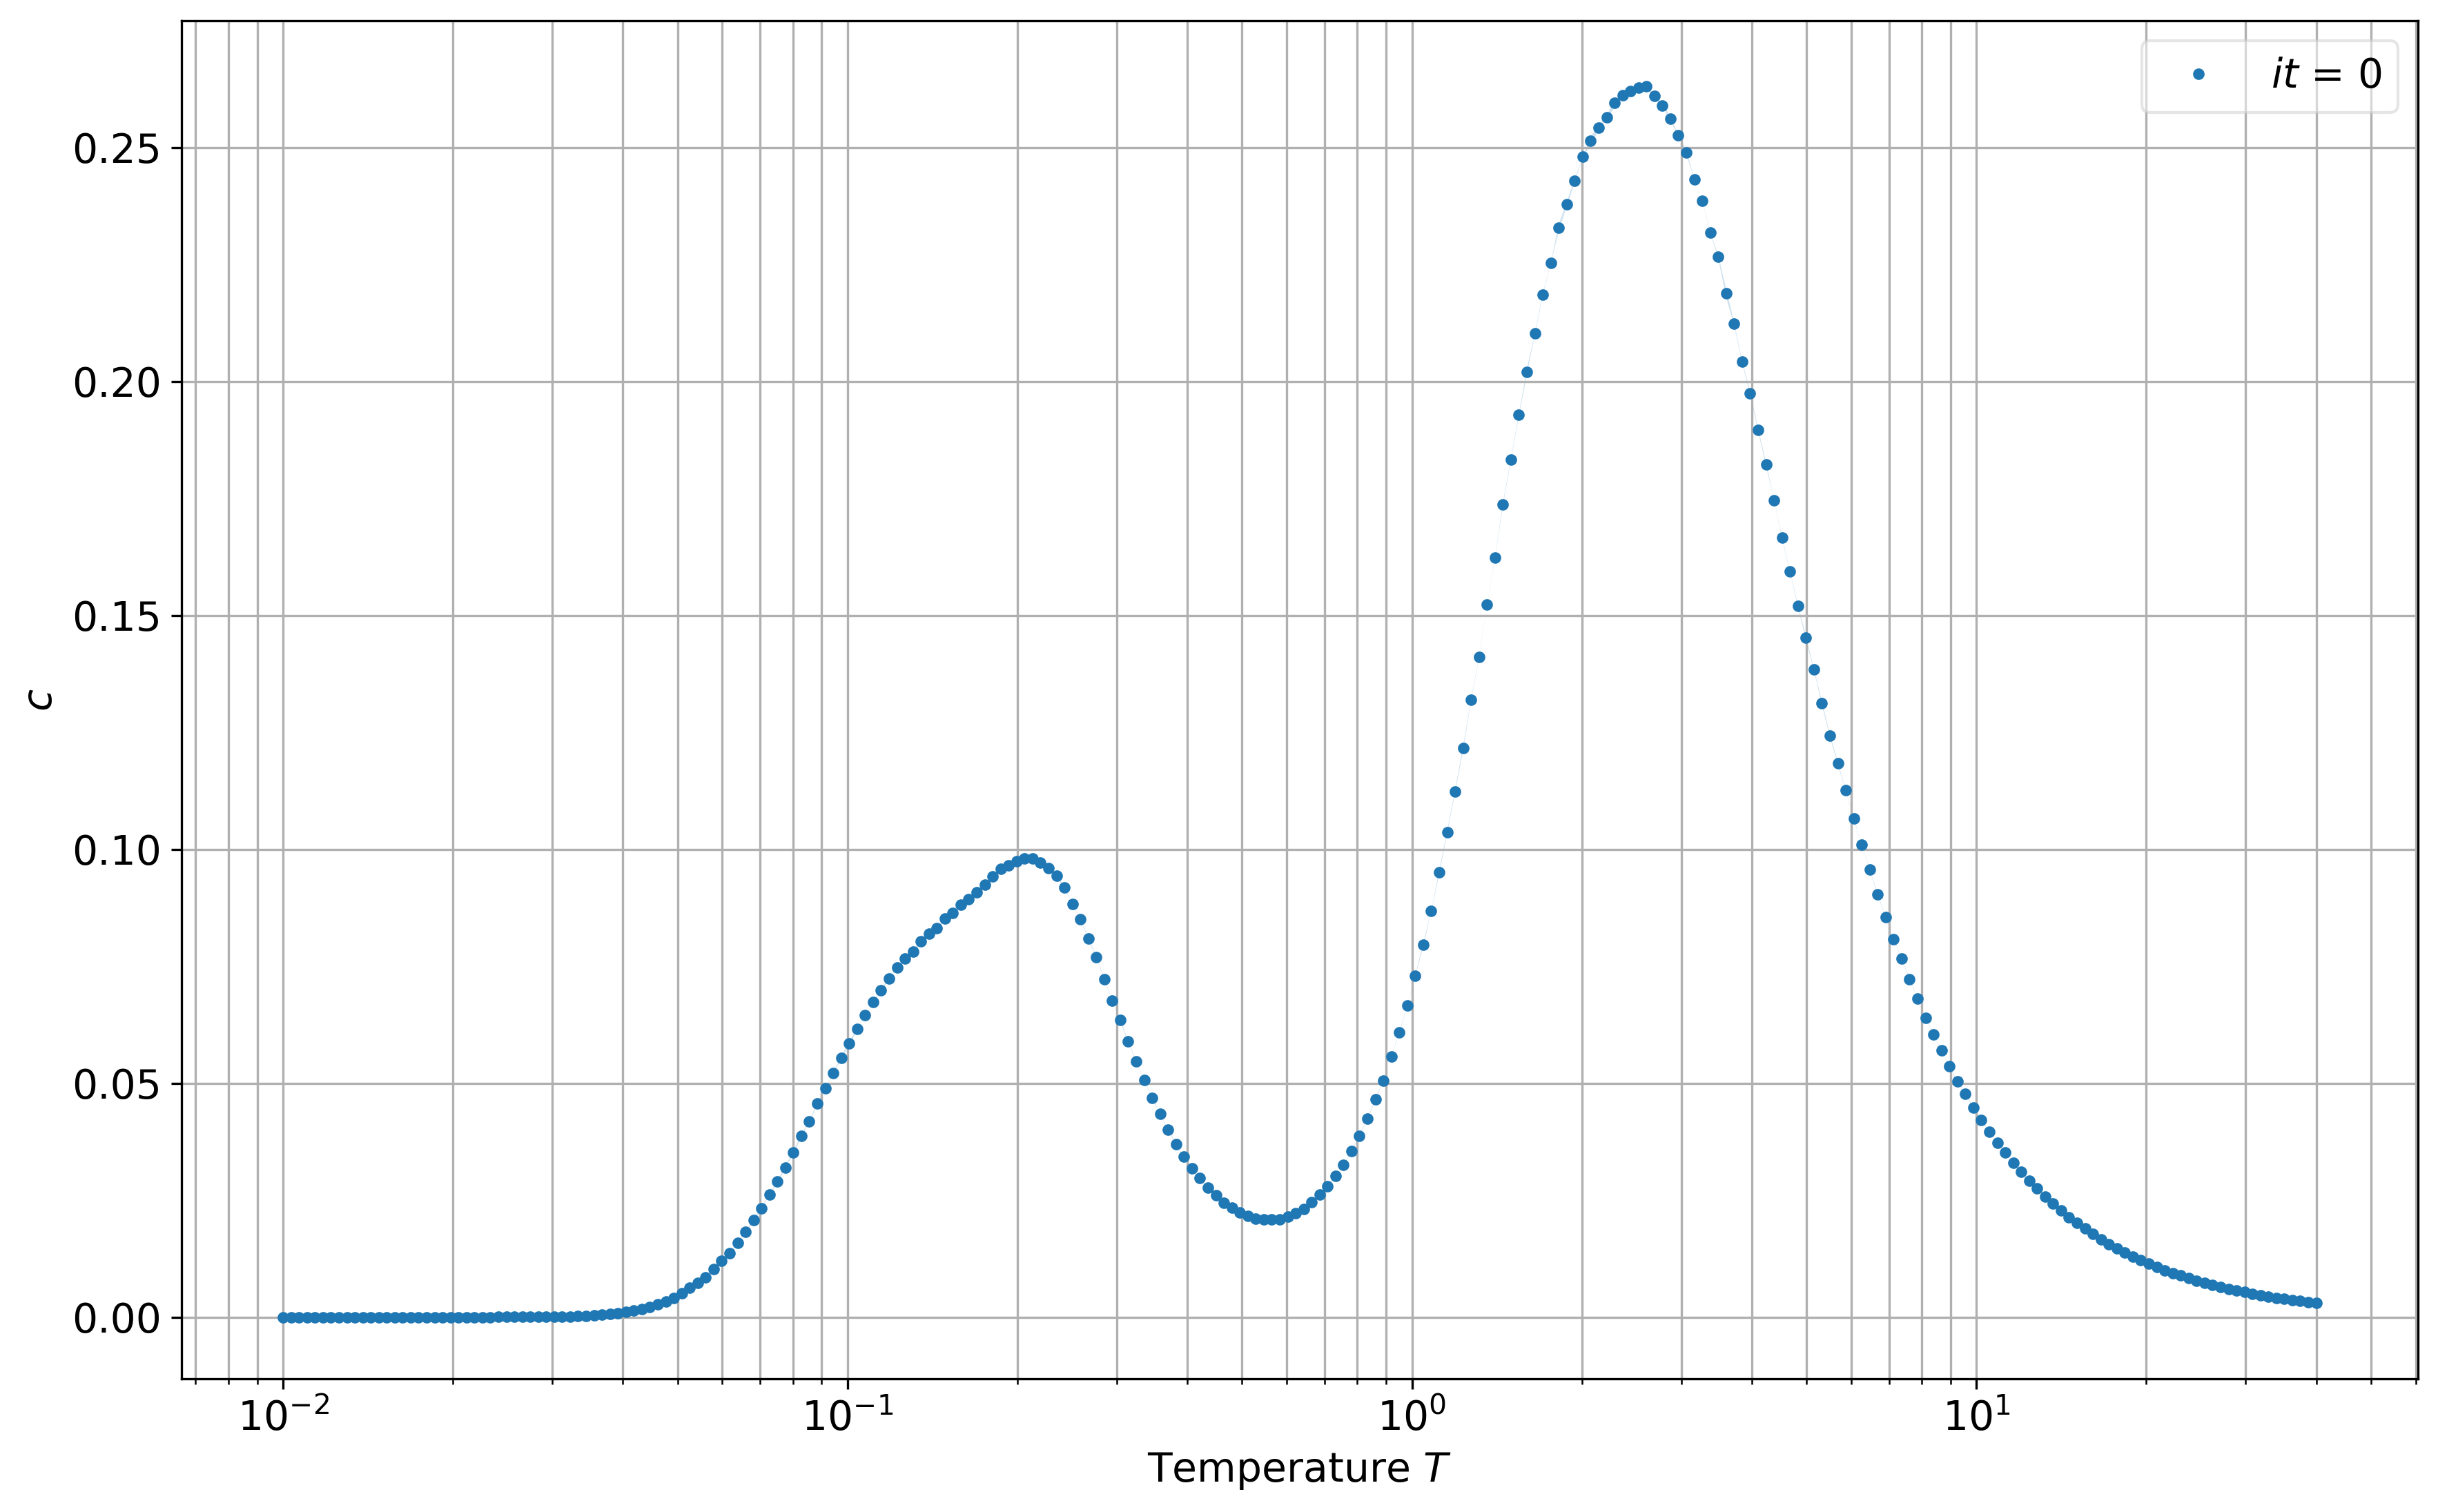

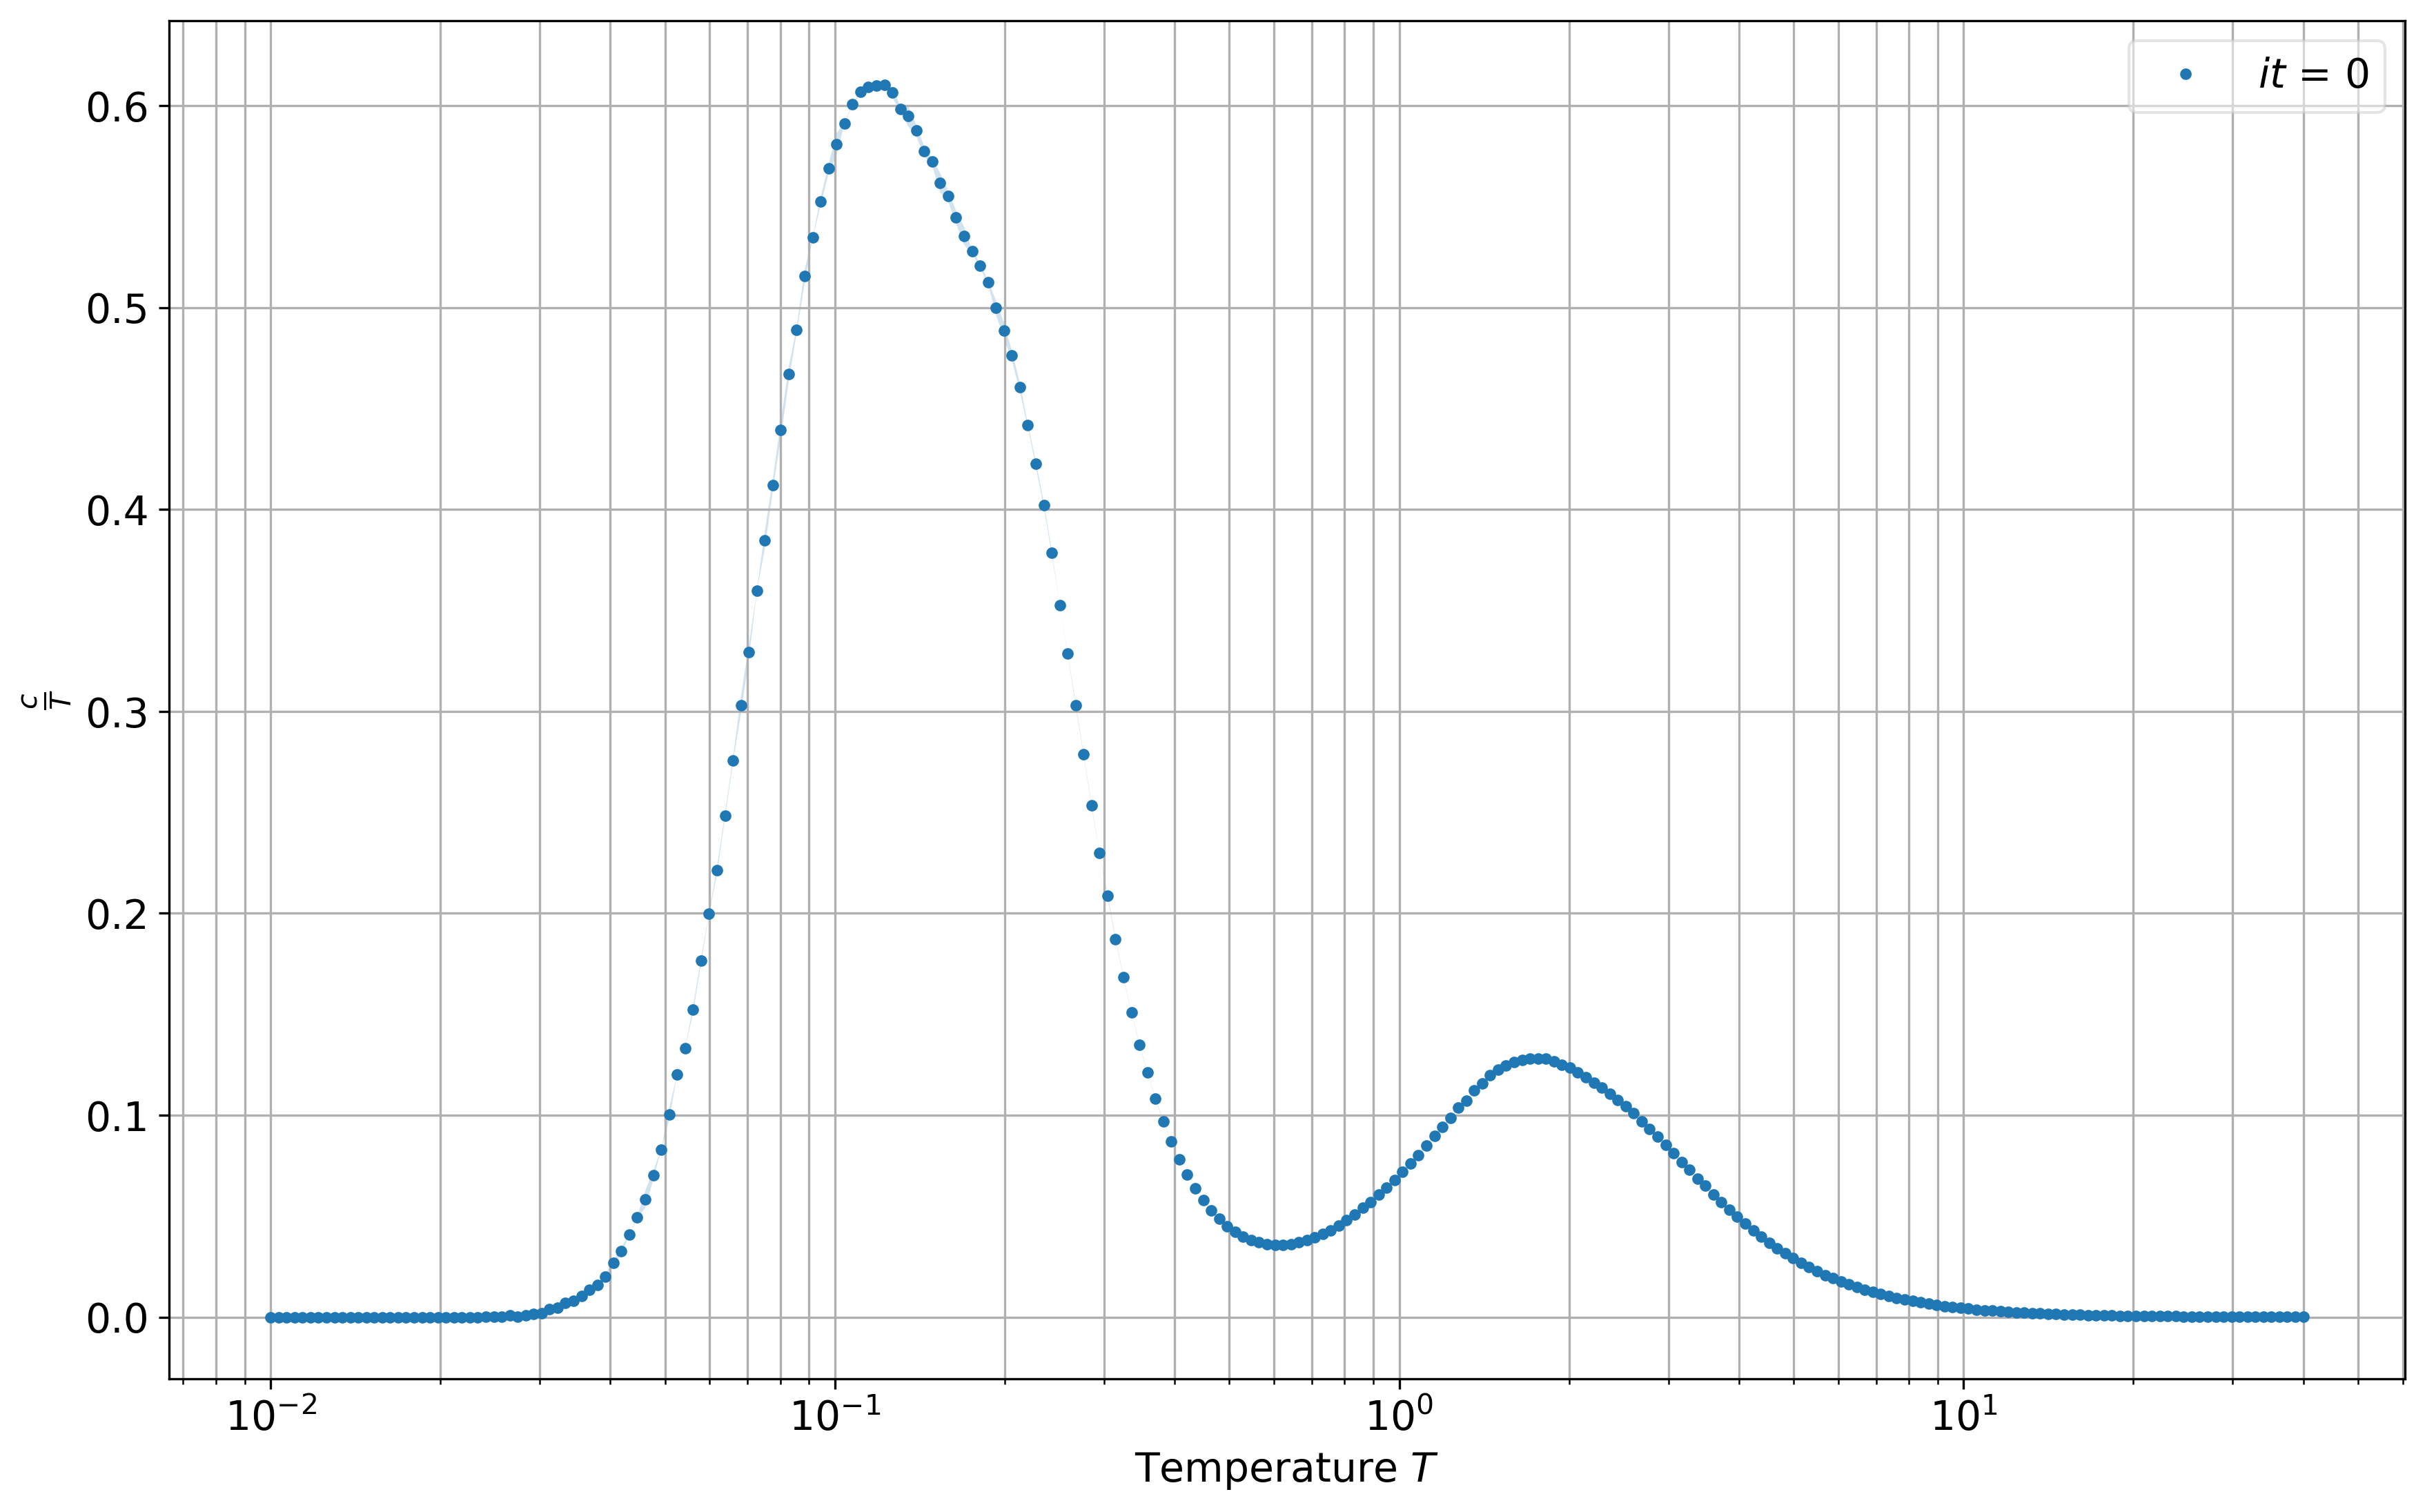

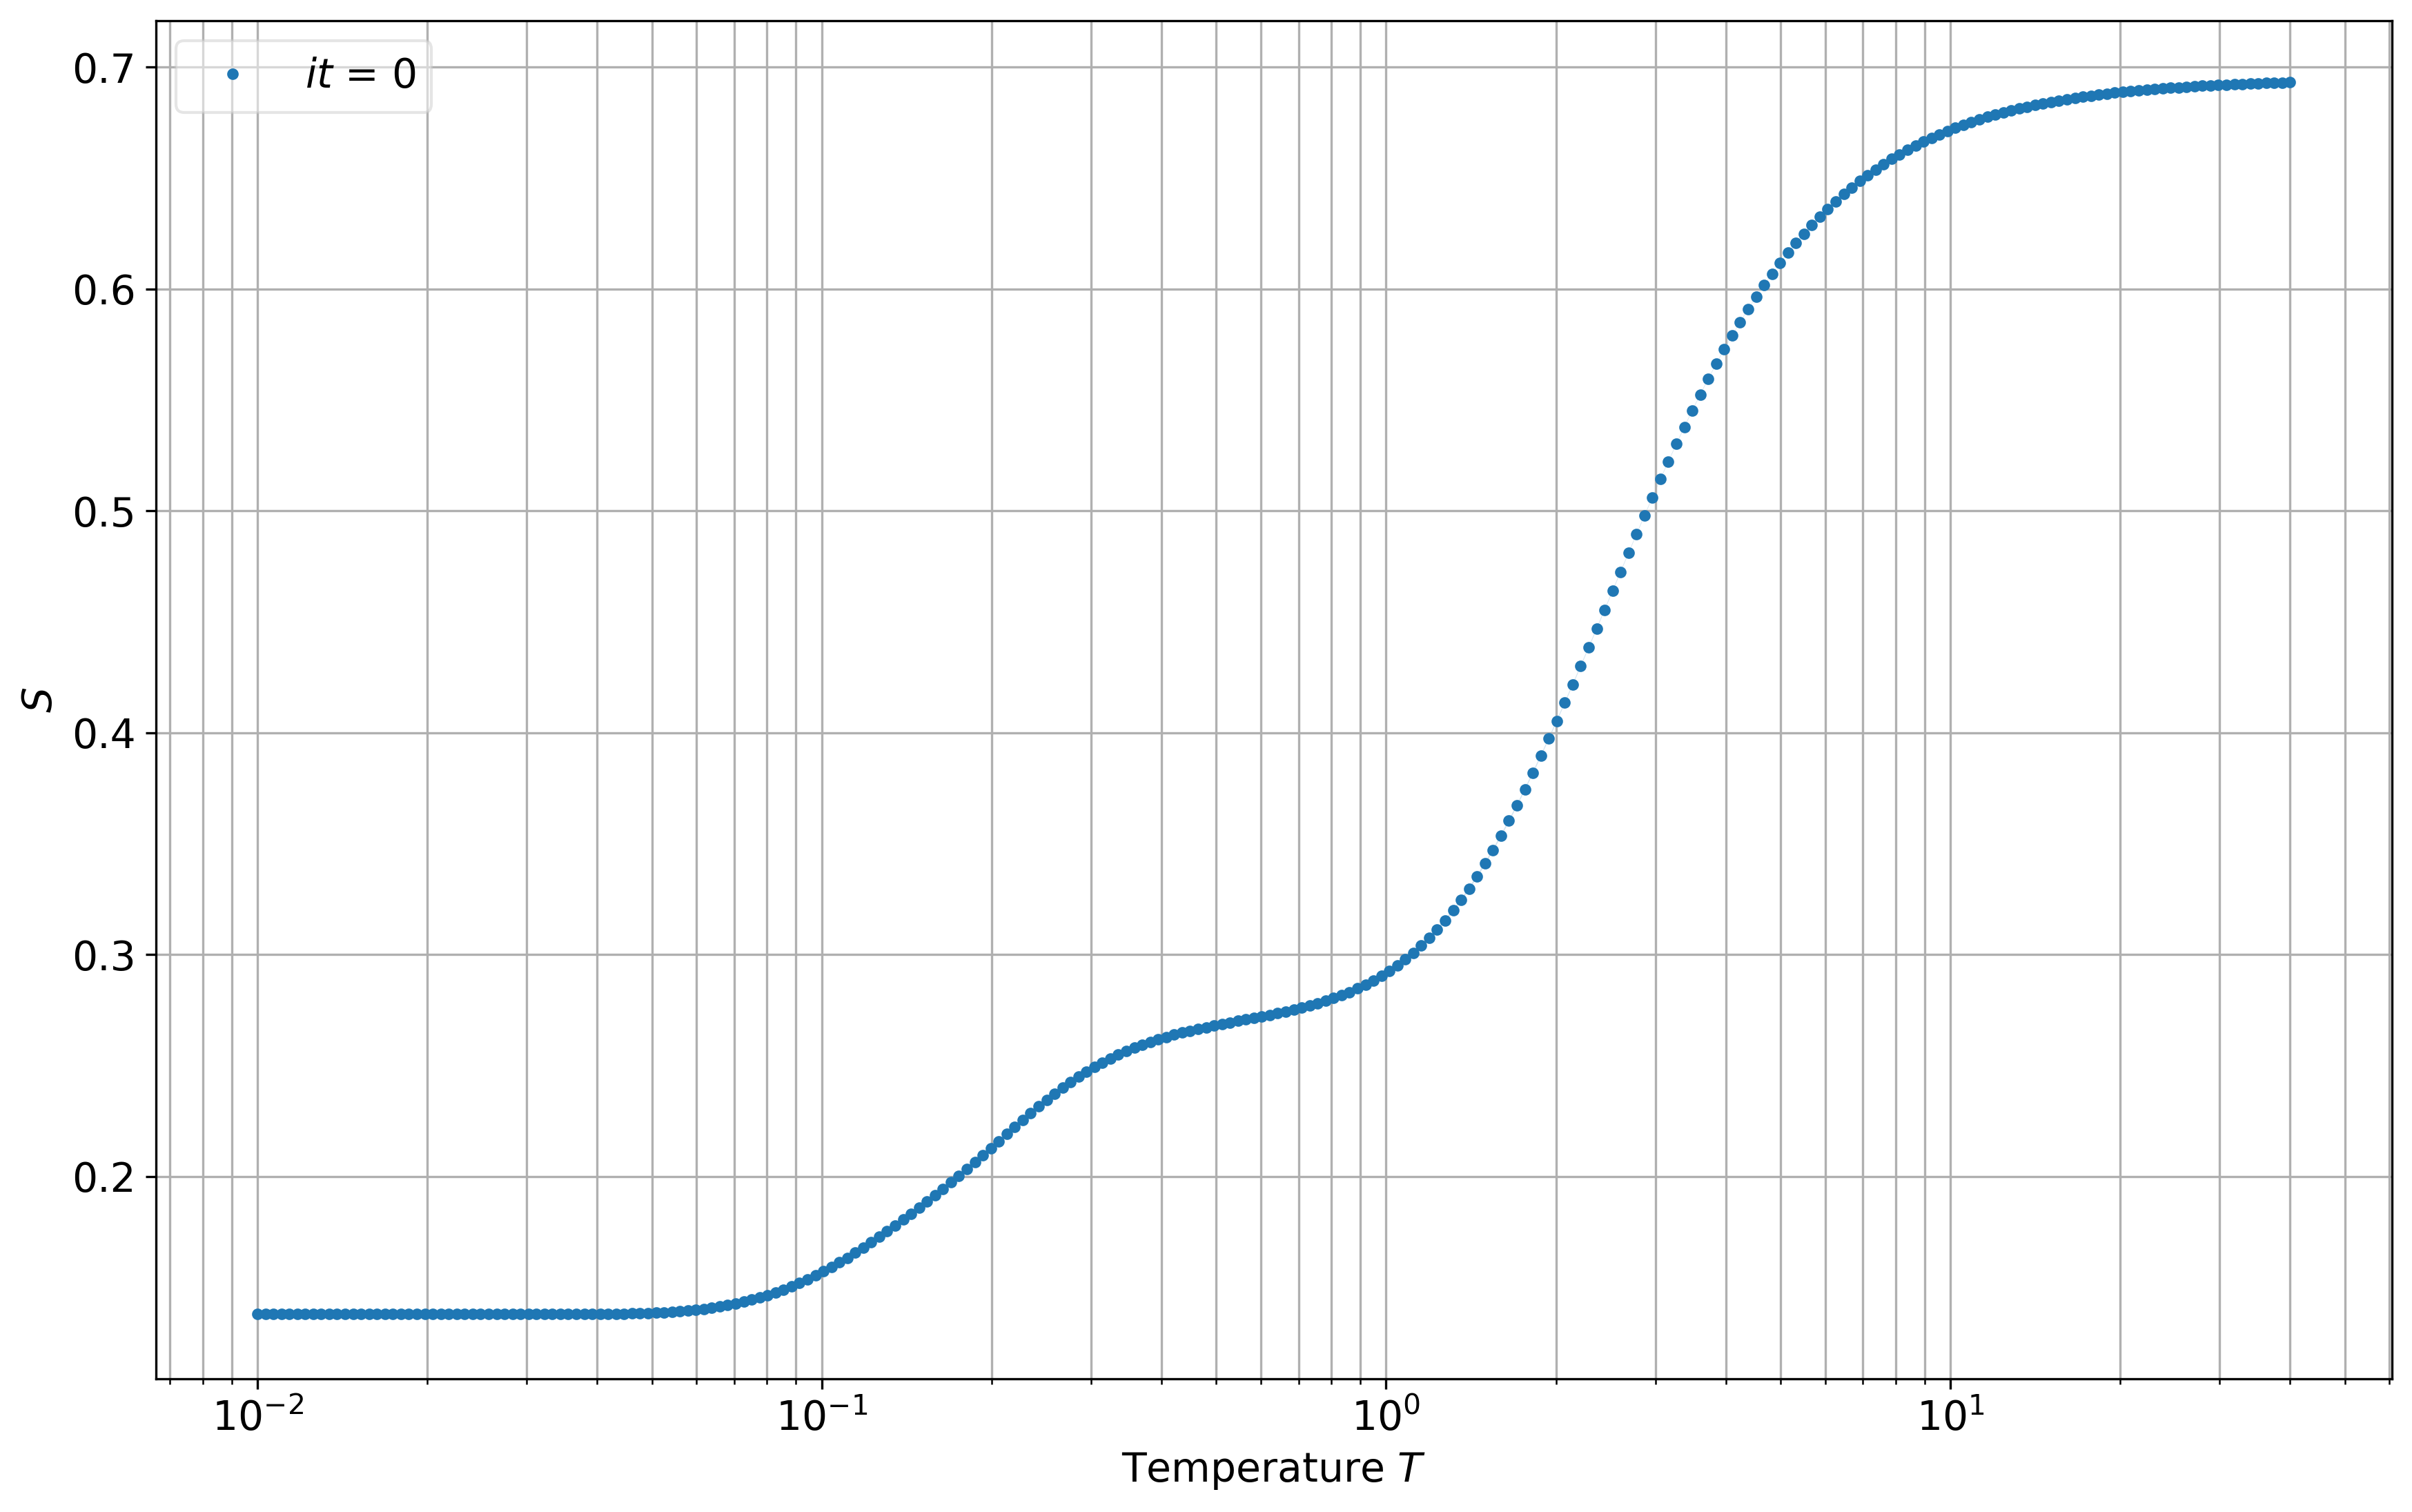

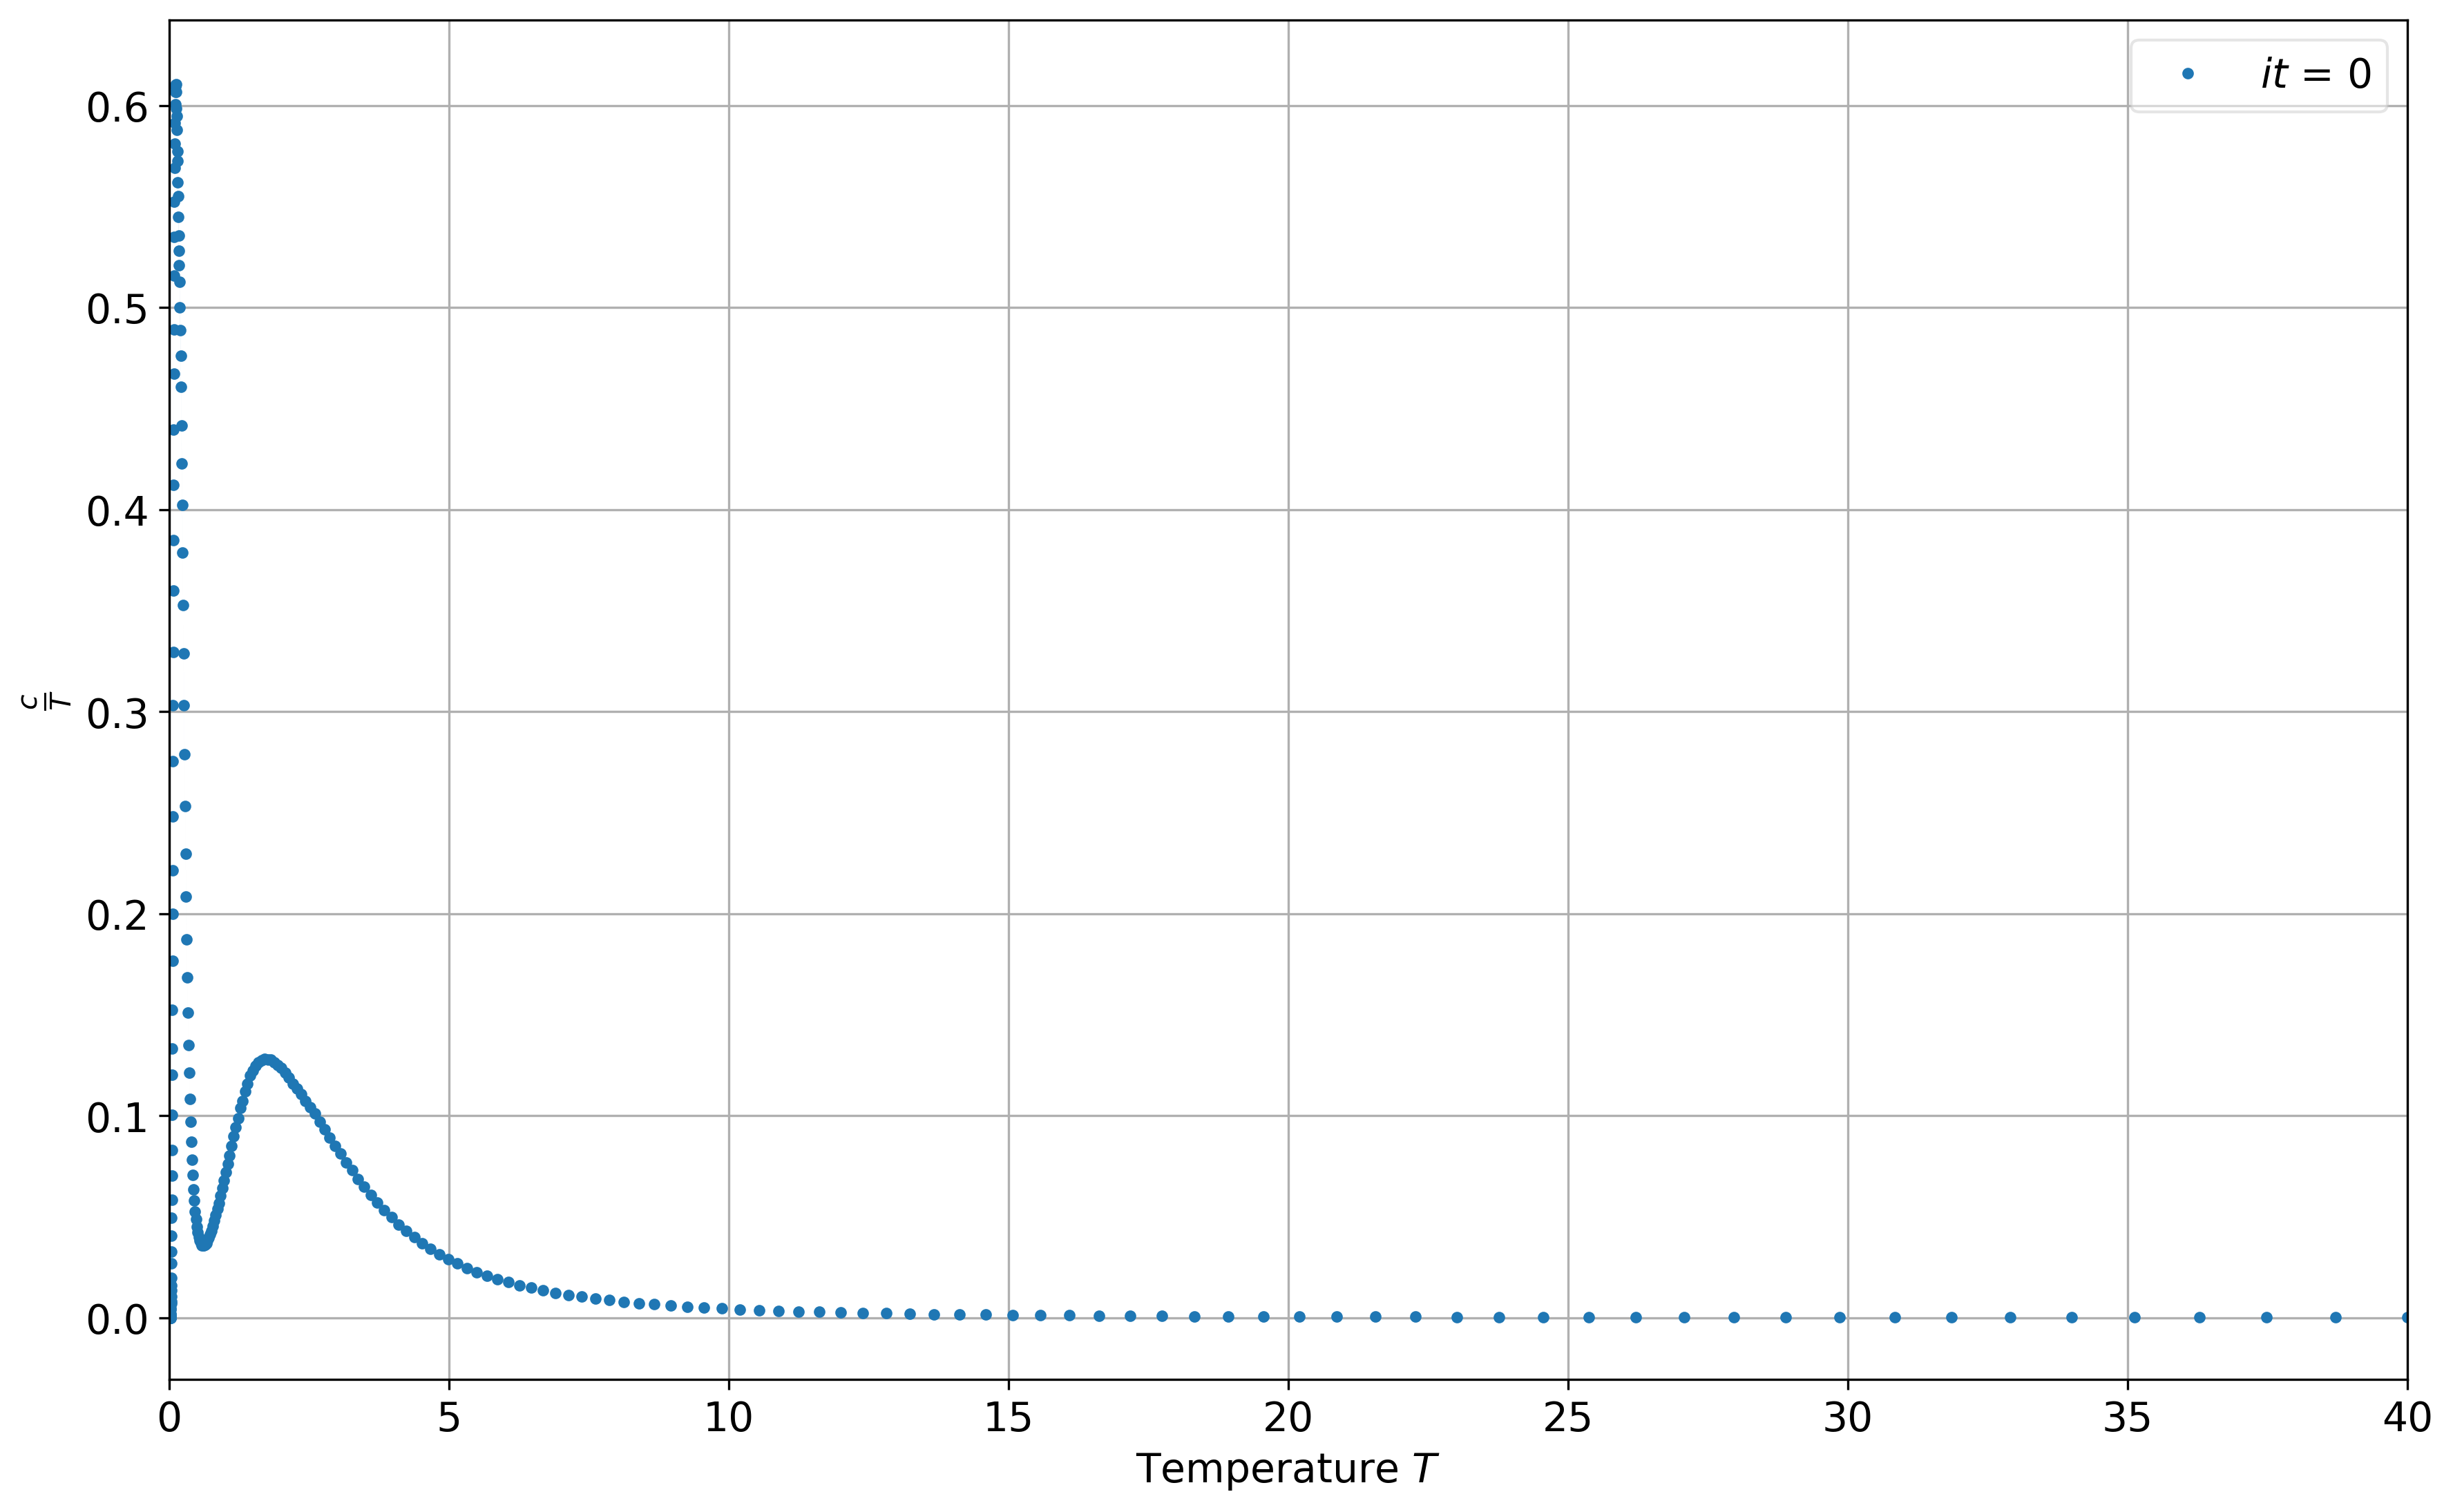

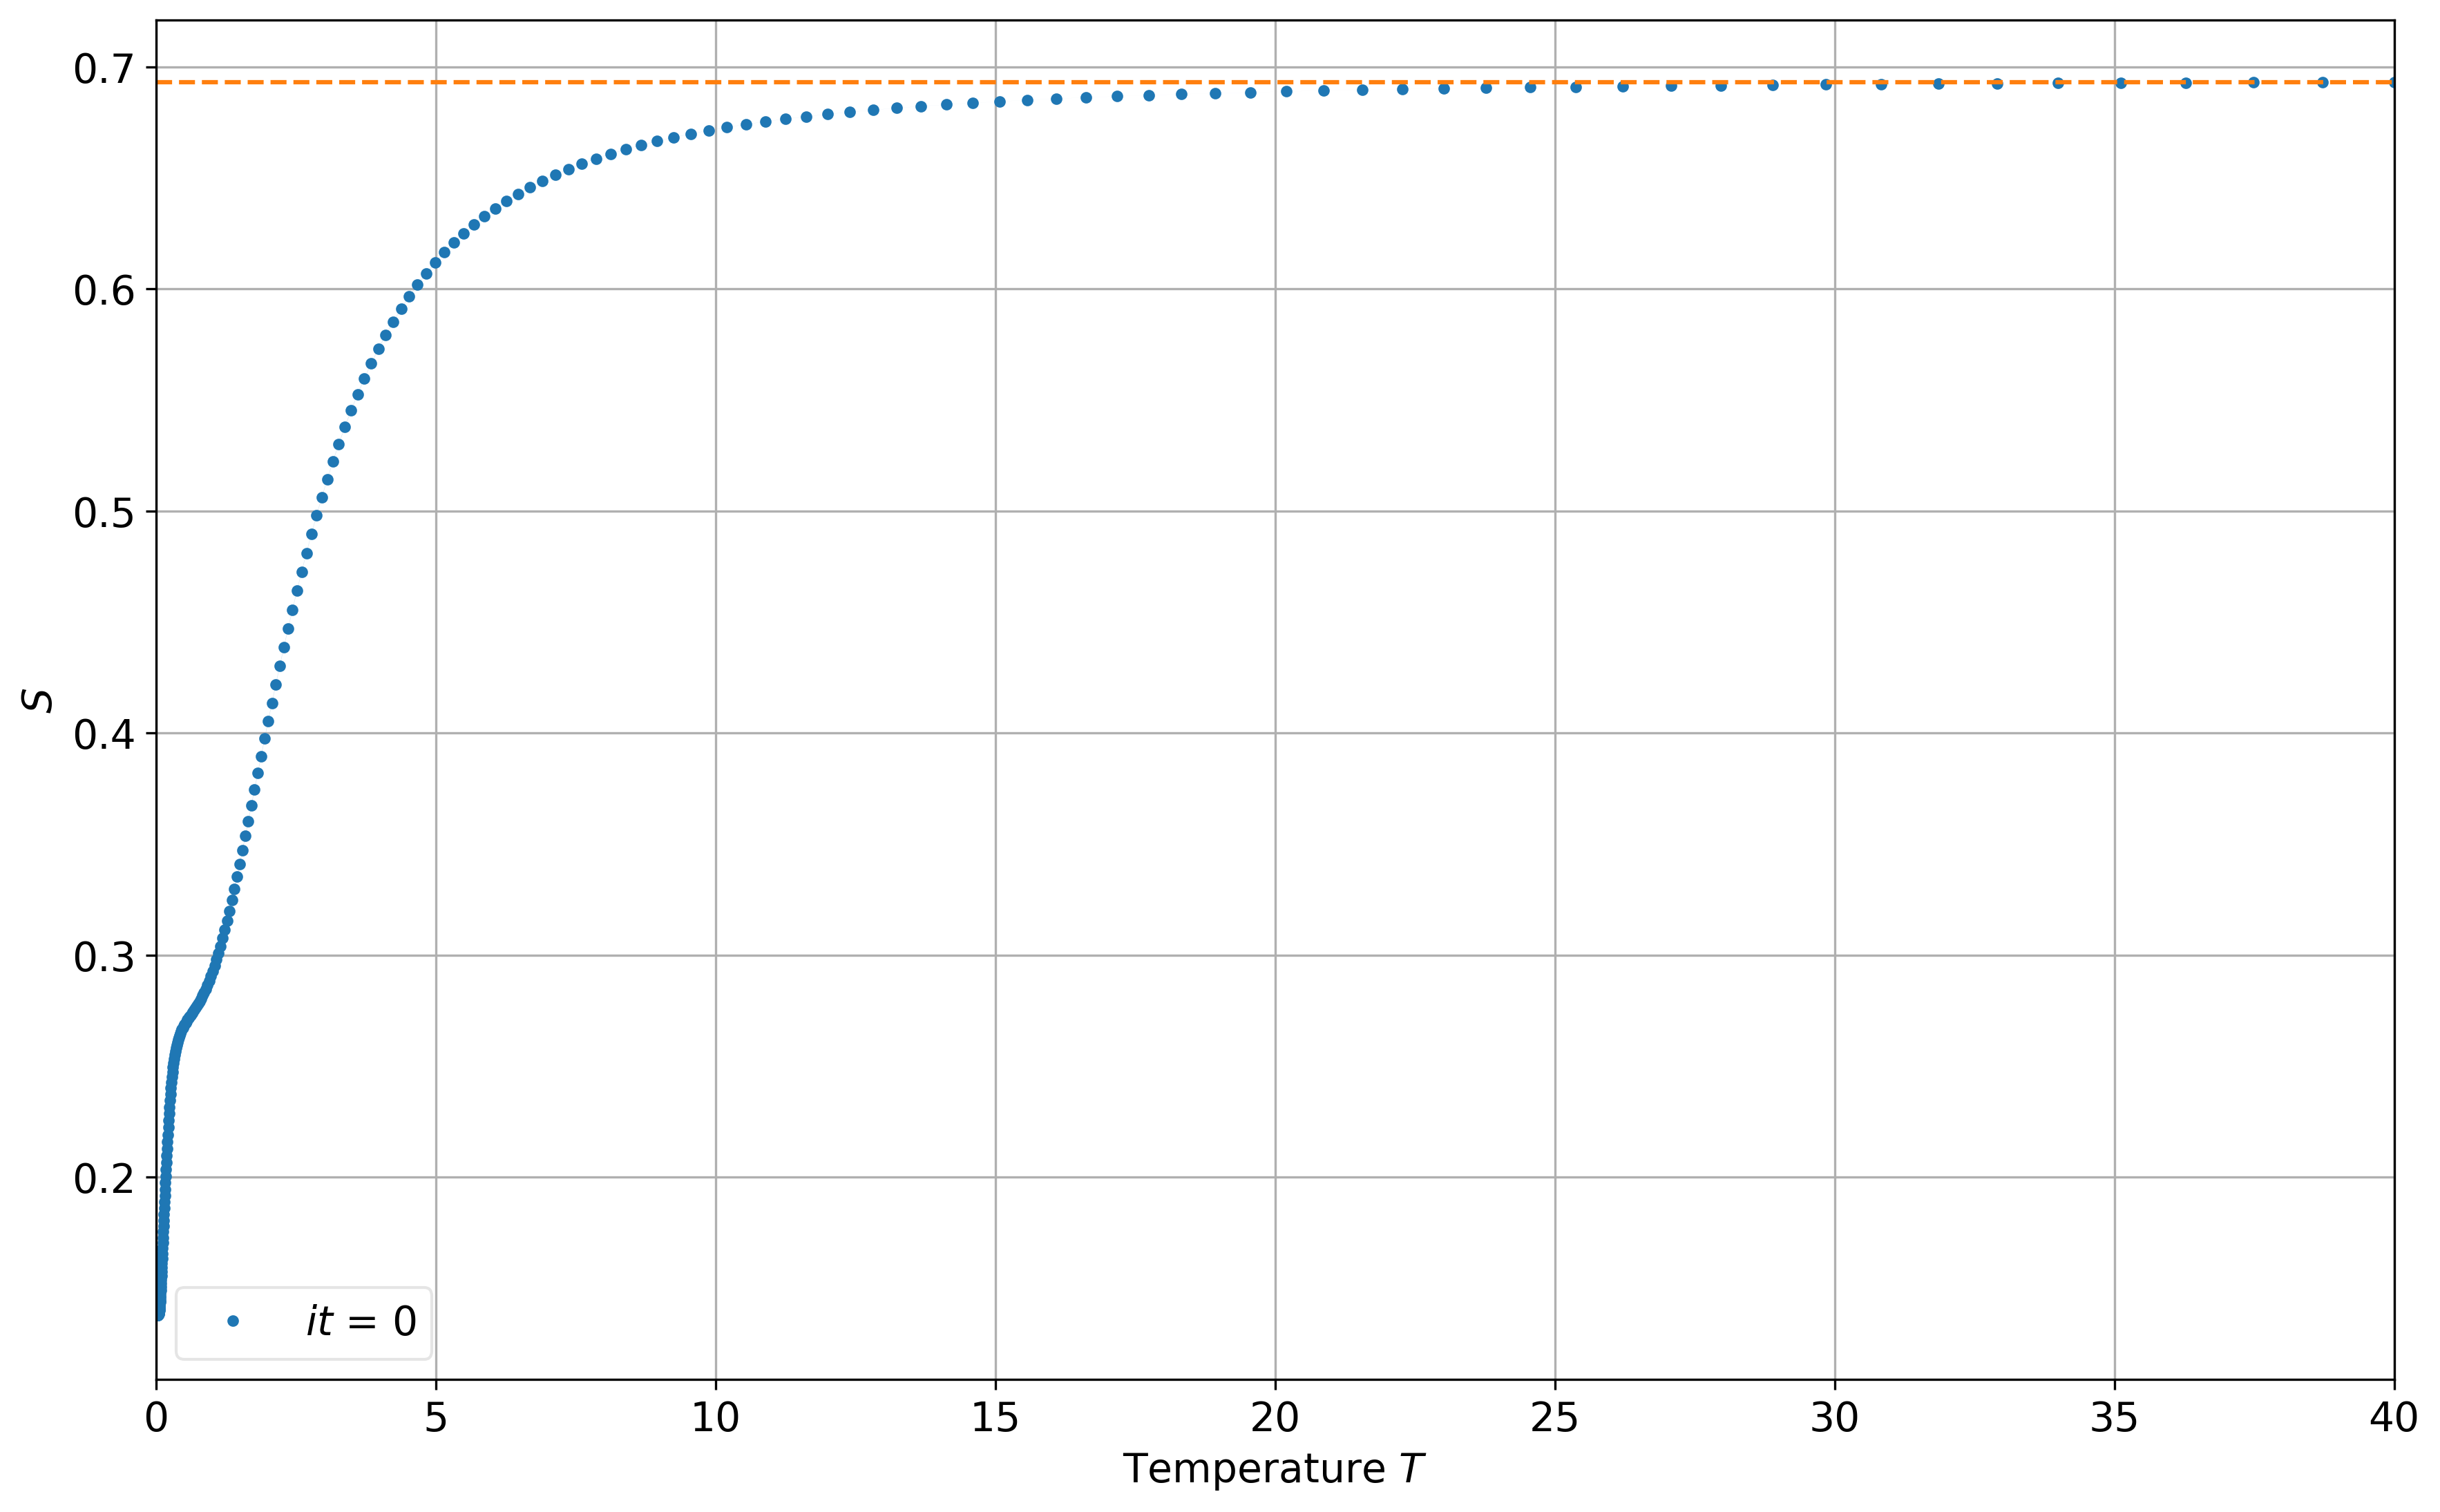

In [12]:
###########################################
        ## STATISTICS ANALYSIS ##
###########################################
#for i in range(n):
#    af.BasicPlotsE(L, i, tidmin, tidmax, temperatures_plots, hfields_plots, foldername,
#                    results_foldername, filenamelist, t_h_MeanE, t_h_MeanEsq, t_h_varMeanE,
#                    t_h_varMeanEsq, C, ErrC, J1, J2, J3, J4, **kw)
#plt.show()
#
if mergeruns:
    nplots = 1
else:
    nplots = n
af.BulkPlotsE(L, nplots, 0, tidmin, tidmax, temperatures_plots, foldername,
                results_foldername, filenamelist, t_h_MeanE, t_h_MeanEsq, t_h_varMeanE,
                t_h_varMeanEsq, C, ErrC, J1, J2, J3, J4, t_h_S, t_h_Smin, t_h_Smax)